Import packages

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import skew, kurtosis
import statsmodels.api as sm
from prettytable import PrettyTable
import os
import sys
from dotenv import load_dotenv
from joblib import Memory

# Load environment variables from a .env file
load_dotenv(dotenv_path='environment_variables.env')

# Setup joblib Memory for caching
cachedir = './cache_directory'  # Set your cache directory
memory = Memory(cachedir, verbose=0)

Import Custom Classes

In [26]:
# Add custom directories to the system path for importing classes
sys.path.extend(['../src/data', '../src/models', '../src/visualization'])

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Import custom classes
from src.models.evaluate_strategy import EvaluateStrategy
from src.models.momentum_strategy import MomentumStrategy
from src.visualization.visualize_results import Visualizer
from src.data.load_data import Dataloader
from src.data.process_data import Dataprocessor

# Create instances of the imported classes
strategy_evaluator = EvaluateStrategy()
momentum = MomentumStrategy()
visualizer = Visualizer()
dataloader = Dataloader()
dataprocessor = Dataprocessor()

Set Environment Variable

In [27]:
# Set and retrieve the project path
ProjectName = 'SPX-Industry-Momentum'
os.environ['RESEARCH_PATH'] = os.environ.get('PROJECT_ROOT')
research_path = os.environ.get('RESEARCH_PATH')

# Check if the path is set and print it
if research_path:
    path = os.path.join(research_path, ProjectName)
    file_path = os.path.join(path, 'data', 'raw')
    picture_path = os.path.join(path, 'reports', 'figures')
    print(f"Project Path: {path}\nData Path: {file_path}")
else:
    print("RESEARCH_PATH environment variable is not set.")

Project Path: /Users/fabianmugrauer/Desktop/Uni/Studium/Master/HS23/Digital Tools/Project/SPX-Industry-Momentum
Data Path: /Users/fabianmugrauer/Desktop/Uni/Studium/Master/HS23/Digital Tools/Project/SPX-Industry-Momentum/data/raw


Import and Process Data

In [28]:

# Decorate the load_data function with joblib cache
load_data_csv_cached = memory.cache(dataloader.load_data_csv)

# Define csv file to load
file_name = 'Bloomberg_Download.csv'

# Load the data using the cached function
dates_dateformat, SPXT, Sectors, Rf, Industry_Groups = load_data_csv_cached(file_path, file_name)

# Decorate the process_data functions with joblib cache
process_data_cached = memory.cache(dataprocessor.process_data)

# Process the data using the cached functions
dates_datetime, numericDate_d, firstDayList, lastDayList, dates4plot, Sectors_returns_d, Sectors_returns_m, sector_names, Industry_Groups_returns_d, Industry_Groups_returns_m, IG_names, SPXT_returns_d, SPXT_returns_m, SPXT_Xsreturns_m, rf_d_unadjusted, rf_d, rf_d_monthly = process_data_cached(dates_dateformat, Sectors, Industry_Groups, SPXT, Rf)

Define Meta-variables for Analysis

In [29]:
# Define analysis parameters
trx_cost = 0.001
nLong = 3
startMonth = 13
lookback_period_start, lookback_period_end = 9, 1
holding_period = 3

Run Sector Momentum Analysis

In [30]:
# Perform the momentum strategy backtest
xsReturns_TC, totalReturns_TC, weights = momentum.backtest_momentum(Sectors_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, 0, trx_cost)
xsReturns_TC_IG, totalReturns_TC_IG, weights_IG = momentum.backtest_momentum(Industry_Groups_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, 0, trx_cost)

# Long / Short implementation
xsReturns_TC_LS, totalReturns_TC_LS, weights_LS = momentum.backtest_momentum(Sectors_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, 3, trx_cost)
xsReturns_TC_IG_LS, totalReturns_TC_IG_LS, weights_IG_LS = momentum.backtest_momentum(Industry_Groups_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end, holding_period, startMonth, nLong, 3, trx_cost)

Analysis Output

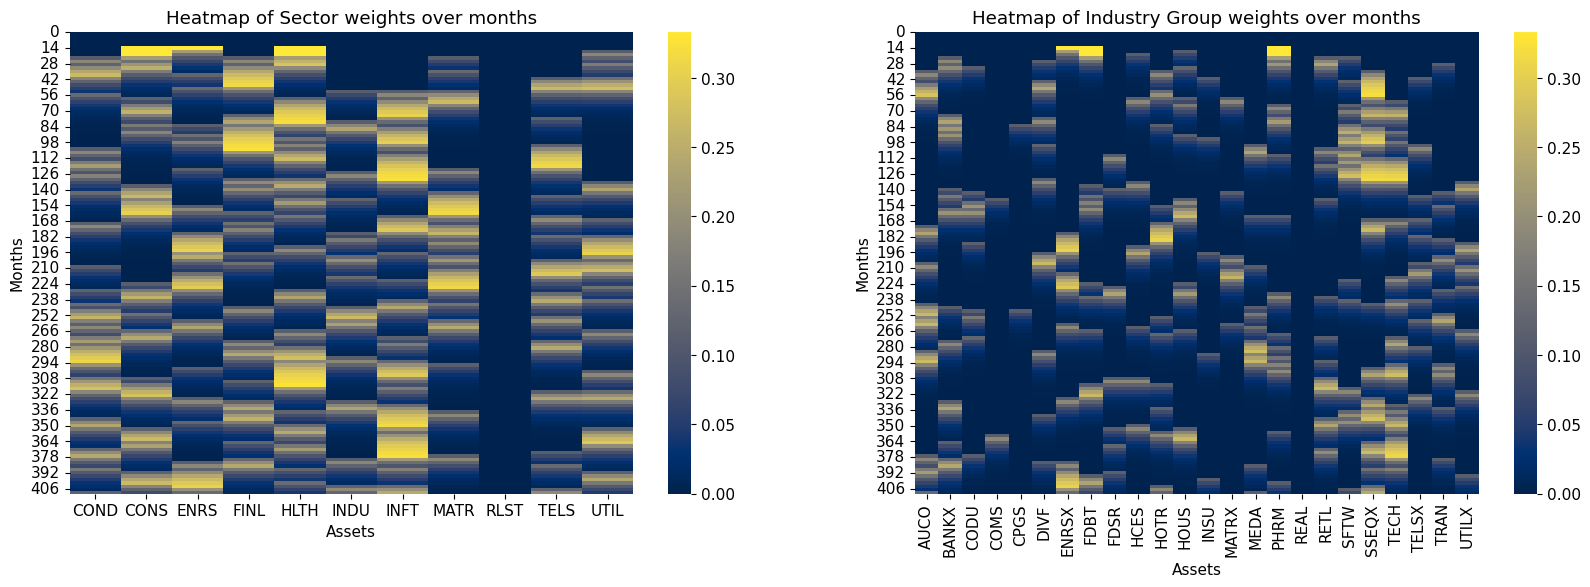

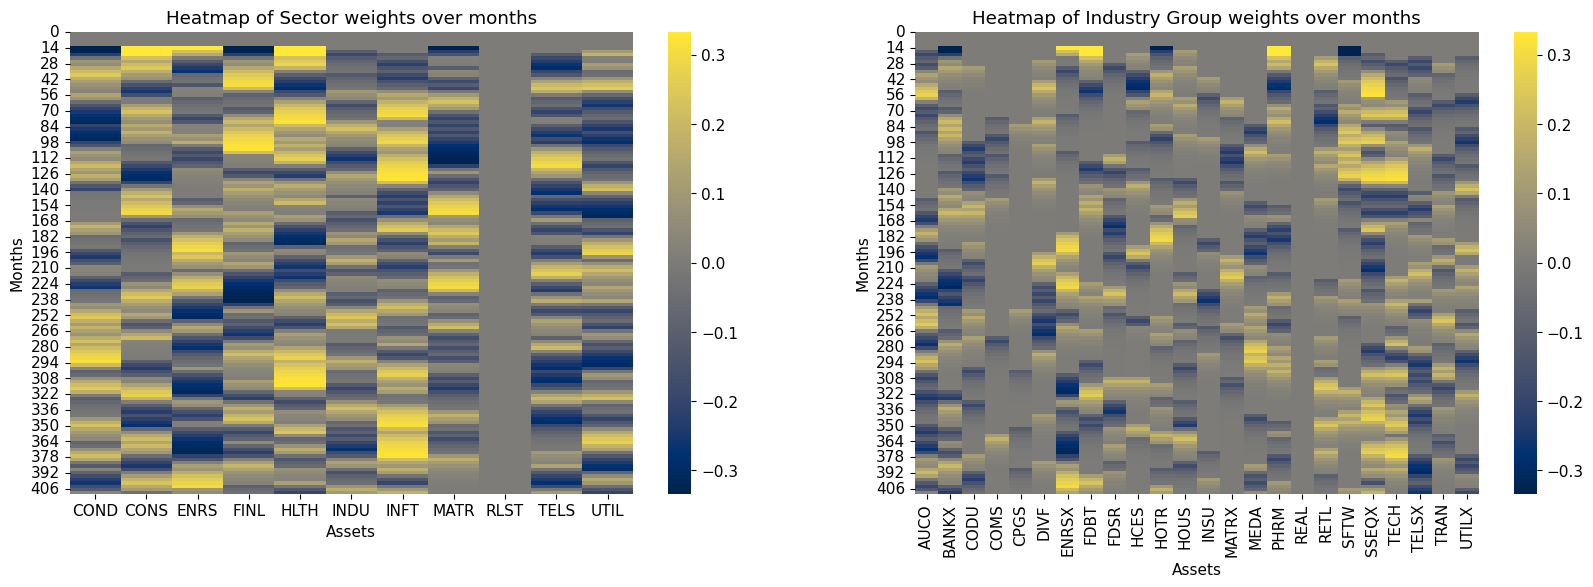

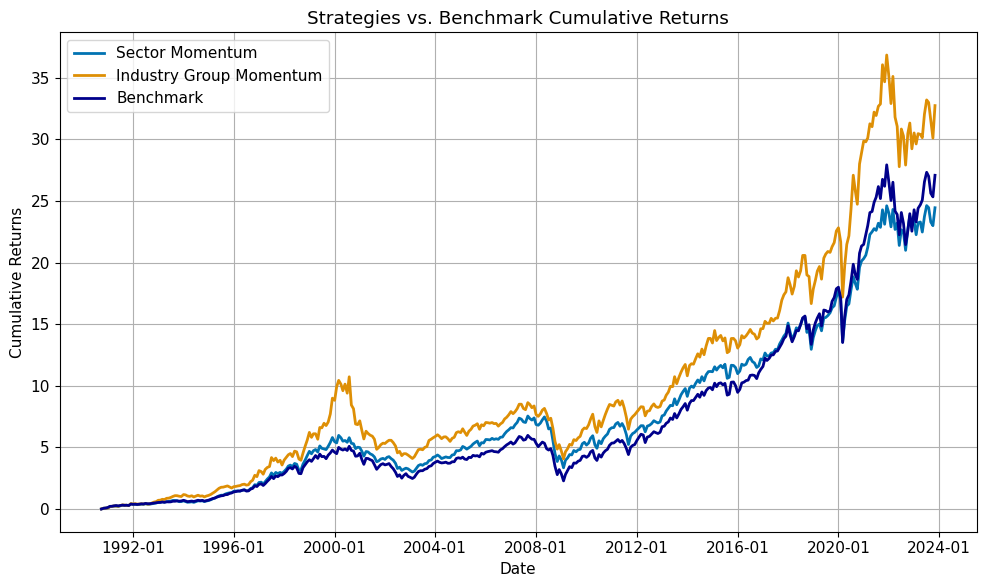

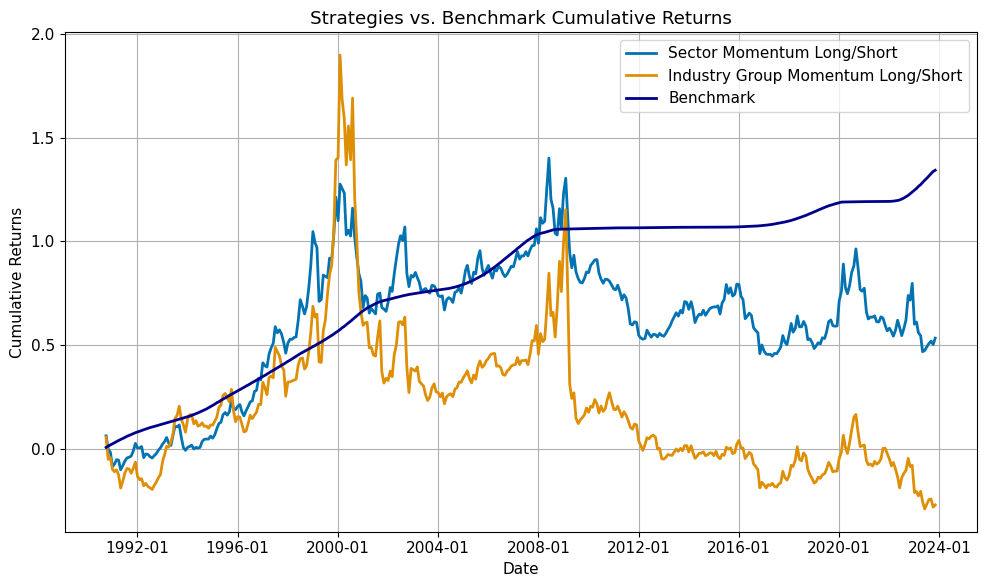

In [31]:
# Visualize the weights using a heatmap

fig1 = visualizer.create_colorheatmap(weights, weights_IG, sector_names, IG_names)
fig1.savefig(os.path.join(picture_path, 'strategy_weights_long.png'), dpi=300)

# Long/Short
fig2 = visualizer.create_colorheatmap(weights_LS, weights_IG_LS, sector_names, IG_names)
fig2.savefig(os.path.join(picture_path, 'strategy_weights_long_short.png'), dpi=300)

# Visualize strategy returns against the benchmark
fig3 = visualizer.plot_strategies_with_benchmark(dates4plot, totalReturns_TC, SPXT_returns_m, 'Sector Momentum', startMonth, totalReturns_TC_IG, 'Industry Group Momentum')
fig3.savefig(os.path.join(picture_path, 'strategy_plot.png'), dpi=300)

fig4 = visualizer.plot_strategies_with_benchmark(dates4plot, totalReturns_TC_LS, rf_d_monthly, 'Sector Momentum Long/Short', startMonth, totalReturns_TC_IG_LS, 'Industry Group Momentum Long/Short')
fig4.savefig(os.path.join(picture_path, 'strategy_plot_long_short.png'), dpi=300)

In [32]:
# Summarize and print performance metrics
ArithmAvgTotalReturn, ArithmAvgXsReturn, StdXsReturns, SharpeArithmetic, MinXsReturn, MaxXsReturn, SkewXsReturn, KurtXsReturn, alphaArithmetic, tvaluealpha, betas, summary_table = strategy_evaluator.summarize_performance(xsReturns_TC, rf_d_monthly, SPXT_Xsreturns_m, 12, startMonth, 'Sectors')
ArithmAvgTotalReturn_IG, ArithmAvgXsReturn_IG, StdXsReturns_IG, SharpeArithmetic_IG, MinXsReturn_IG, MaxXsReturn_IG, SkewXsReturn_IG, KurtXsReturn_IG, alphaArithmetic_IG, tvaluealpha_IG, betas_IG, summary_table_IG = strategy_evaluator.summarize_performance(xsReturns_TC_IG, rf_d_monthly, SPXT_Xsreturns_m, 12, startMonth, 'Industry Groups')
print(summary_table)
print(summary_table_IG)

+--------------------------------+
|            Sectors             |
+----------------------+---------+
|      Statistic       |  Value  |
+----------------------+---------+
| ArithmAvgTotalReturn |  10.946 |
|  ArithmAvgXsReturn   |  8.375  |
|     StdXsReturns     |  15.030 |
|   SharpeArithmetic   |  0.557  |
|   SharpeGeometric    |  0.509  |
|     MinXsReturn      | -18.812 |
|     MaxXsReturn      |  14.138 |
|     SkewXsReturn     |  -0.613 |
|     KurtXsReturn     |  1.818  |
|         Beta         |  0.906  |
+----------------------+---------+
+--------------------------------+
|        Industry Groups         |
+----------------------+---------+
|      Statistic       |  Value  |
+----------------------+---------+
| ArithmAvgTotalReturn |  12.283 |
|  ArithmAvgXsReturn   |  9.712  |
|     StdXsReturns     |  17.964 |
|   SharpeArithmetic   |  0.541  |
|   SharpeGeometric    |  0.478  |
|     MinXsReturn      | -20.091 |
|     MaxXsReturn      |  16.012 |
|     SkewXsReturn  

Robustness Checks

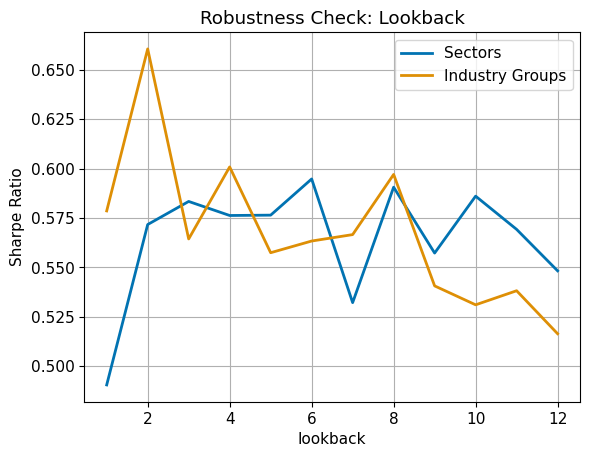

In [33]:
# Define parameters and initialize empty lists or arrays
lookback_period_range = range(1, 13)  # Example range from 3 to 12

# Perform the robustness check for lookback period
sharpe_ratios_lookback = EvaluateStrategy.perform_robustness_check(
    momentum, 'lookback', lookback_period_range, Sectors_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

sharpe_ratios_lookback_IG = EvaluateStrategy.perform_robustness_check(
    momentum, 'lookback', lookback_period_range, Industry_Groups_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

# Plot the results for lookback period robustness check
fig5 = visualizer.plot_robustness_check(lookback_period_range, sharpe_ratios_lookback, 'lookback', sharpe_ratios_lookback_IG, ['Sectors', 'Industry Groups']) 
fig5.savefig(os.path.join(picture_path, 'robustness_check_lb.png'), dpi=300)

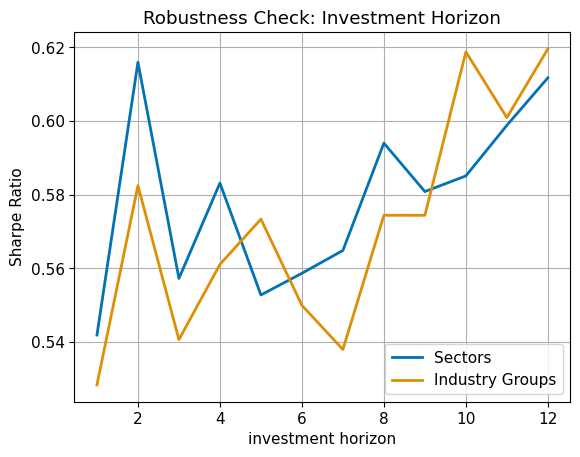

In [34]:
# Define the range for the investment horizon
investment_horizon_range = range(1, 13)  # Example range

# Perform the robustness check for investment horizon
sharpe_ratios_investment_horizon = EvaluateStrategy.perform_robustness_check(
    momentum, 'investment_horizon', investment_horizon_range, Sectors_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

sharpe_ratios_investment_horizon_IG = EvaluateStrategy.perform_robustness_check(
    momentum, 'investment_horizon', investment_horizon_range, Industry_Groups_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

# Plot the results for investment horizon robustness check
fig6 = visualizer.plot_robustness_check(investment_horizon_range, sharpe_ratios_investment_horizon, 'investment_horizon', sharpe_ratios_investment_horizon_IG, ['Sectors', 'Industry Groups'])
fig6.savefig(os.path.join(picture_path, 'robustness_check_ih.png'), dpi=300)

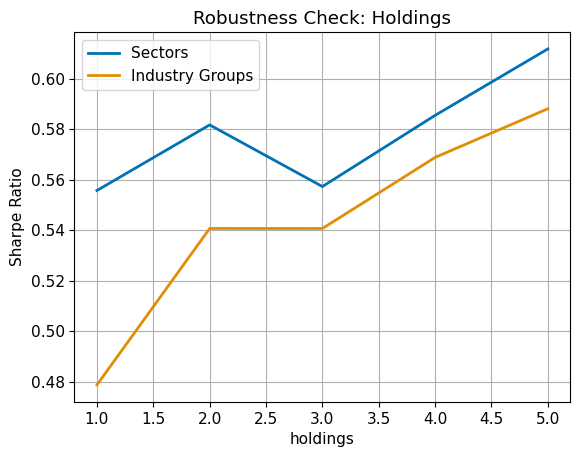

In [35]:
# Define the range for the number of holdings
holdings_range = range(1, 6)  # Example range

# Perform the robustness check for number of holdings
sharpe_ratios_holdings = EvaluateStrategy.perform_robustness_check(
    momentum, 'holdings', holdings_range, Sectors_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

sharpe_ratios_holdings_IG = EvaluateStrategy.perform_robustness_check(
    momentum, 'holdings', holdings_range, Industry_Groups_returns_m, rf_d_monthly, 
    SPXT_returns_m, lookback_period_end, startMonth, nLong, 0, trx_cost, holding_period
)

# Plot the results for number of holdings robustness check
fig7 = visualizer.plot_robustness_check(holdings_range, sharpe_ratios_holdings, 'holdings', sharpe_ratios_holdings_IG,['Sectors', 'Industry Groups'])
fig7.savefig(os.path.join(picture_path, 'robustness_check_holdings.png'), dpi=300)

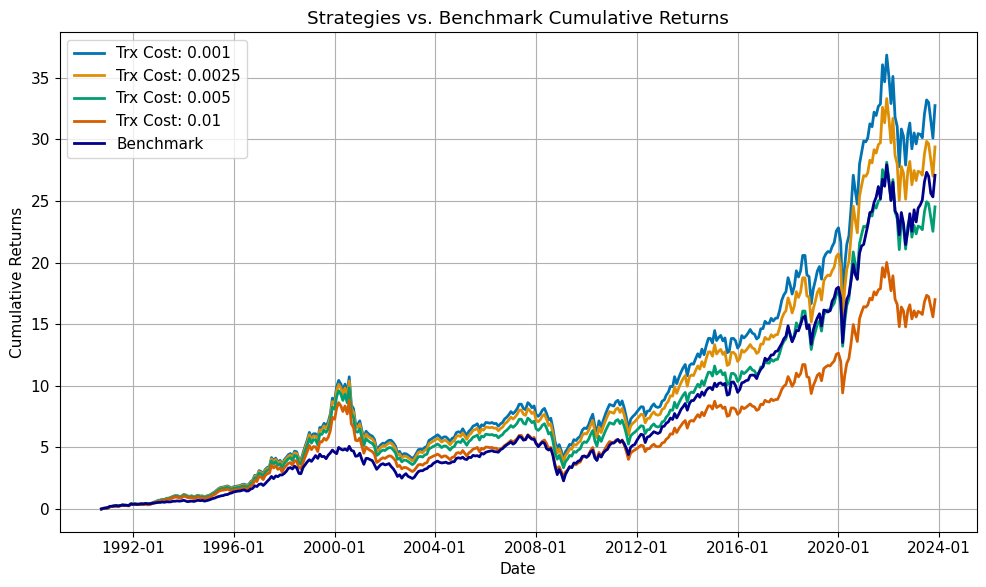

In [36]:
tx_costs = [0.001, 0.0025, 0.005, 0.01]
total_returns_tx_costs = []
total_returns_tx_costs_IG  = []
labels = []

for trx_cost in tx_costs:
    _, totalReturns_TC, _ = momentum.backtest_momentum(
        Sectors_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end,
        holding_period, startMonth, nLong, 0, trx_cost
    )

    _, totalReturns_TC_IG, _ = momentum.backtest_momentum(
        Industry_Groups_returns_m, rf_d_monthly, lookback_period_start, lookback_period_end,
        holding_period, startMonth, nLong, 0, trx_cost
    )

    # Storing the total returns in a list
    total_returns_tx_costs.append(totalReturns_TC)
    total_returns_tx_costs_IG.append(totalReturns_TC_IG)

    # Creating corresponding labels
    labels.append(f'Trx Cost: {trx_cost}')

fig8 = visualizer.plot_strategies_with_benchmark(dates4plot, total_returns_tx_costs_IG, SPXT_returns_m, labels, startMonth)
fig8.savefig(os.path.join(picture_path, 'robustness_check_tc.png'), dpi=300)